In [ ]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import math

# Choosing which GPU this notebook can access
# (useful when running multiple experiments in parallel, on different GPUs):
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

# Some hyper-parameters:
input_shape = [224, 224, 3] # We will resize the input images to this shape
batch_size  = 32            # Images per batch (reduce/increase according to the machine's capability)
num_epochs  = 2             # Max number of training epochs
random_seed = 42            # Seed for some random operations, for reproducibility

In [ ]:
cd ..

/


In [ ]:
import cifar_utils

cifar_info = cifar_utils.get_info()
print(cifar_info)

# Number of classes:
num_classes = cifar_info.features['label'].num_classes

# Number of images:
num_train_imgs = cifar_info.splits['train'].num_examples
num_val_imgs = cifar_info.splits['test'].num_examples

train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch   = math.ceil(num_val_imgs / batch_size)

tfds.core.DatasetInfo(
    name='cifar100',
    full_name='cifar100/3.0.2',
    description="""
    This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir=PosixGPath('/tmp/tmpc28wtc2btfds'),
    file_format=tfrecord,
    download_size=160.71 MiB,
    dataset_size=132.03 MiB,
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=int64, num_classes=20),
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=100),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=Fa

In [ ]:
train_cifar_dataset = cifar_utils.get_dataset(
    phase='train', batch_size=batch_size, num_epochs=num_epochs, shuffle=True,
    input_shape=input_shape, seed=random_seed)

val_cifar_dataset = cifar_utils.get_dataset(
    phase='test', batch_size=batch_size, num_epochs=1, shuffle=False,
    input_shape=input_shape, seed=random_seed)

Reusing ResNet-50 from Keras Apps
we will instantiate a ResNet-50 model, with **randomly-initialized parameters**


In [ ]:
resnet50 = tf.keras.applications.resnet50.ResNet50(
    include_top=True, weights=None,
    input_shape=input_shape, classes=num_classes)
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

Training the Network
Once instantiated, our model from Keras Applications is like any ohter Keras model. Exactly as we did previously, we will train it on CIFAR:

In [ ]:
import collections
import functools
from keras_custom_callbacks import SimpleLogCallback

# Defining a custom metrics (top-5 accuracy), from a more generic one provided by Keras:
accuracy_metric = tf.metrics.SparseCategoricalAccuracy(name='acc')
top5_accuracy_metric = tf.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_acc')

metrics_to_print = collections.OrderedDict([("loss", "loss"),
                                            ("v-loss", "val_loss"),
                                            ("acc", "acc"),
                                            ("v-acc", "val_acc"),
                                            ("top5-acc", "top5_acc"),
                                            ("v-top5-acc", "val_top5_acc")])

# Defining optimizer and callbacks for the training:
optimizer = tf.keras.optimizers.Adam()

model_dir = './models/resnet_keras_app'
callbacks = [
    # Callback to interrupt the training if the validation loss/metrics stops improving for some epochs:
    tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_acc',
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model, e.g., every 5 epochs:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=5),
    # Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1/2):
    SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=1)
]

# Finally, compiling and training:
resnet50.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',
                 metrics=[accuracy_metric, top5_accuracy_metric])

history = resnet50.fit(train_cifar_dataset,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
                       validation_data=val_cifar_dataset, validation_steps=val_steps_per_epoch,
                       verbose=1, callbacks=callbacks)

Training: start.
Epoch 1/2
   6/1563 [..............................] - ETA: 8:53 - loss: 7.4250 - acc: 0.0260 - top5_acc: 0.0677

1563/1563 [==============================] - 606s 368ms/step - loss: 4.1762 - acc: 0.0701 - top5_acc: 0.2424 - val_loss: 3.9120 - val_acc: 0.1153 - val_top5_acc: 0.3417
Epoch 2/2
1562/1563 [============================>.] - ETA: 0s - loss: 3.5919 - acc: 0.1519 - top5_acc: 0.4012

Epoch  1/2: loss = 3.592; v-loss = 3.326; acc = 0.152; v-acc = 0.207; top5-acc = 0.401; v-top5-acc = 0.491
1563/1563 [==============================] - 563s 360ms/step - loss: 3.5919 - acc: 0.1519 - top5_acc: 0.4012 - val_loss: 3.3259 - val_acc: 0.2073 - val_top5_acc: 0.4912
Training: end.


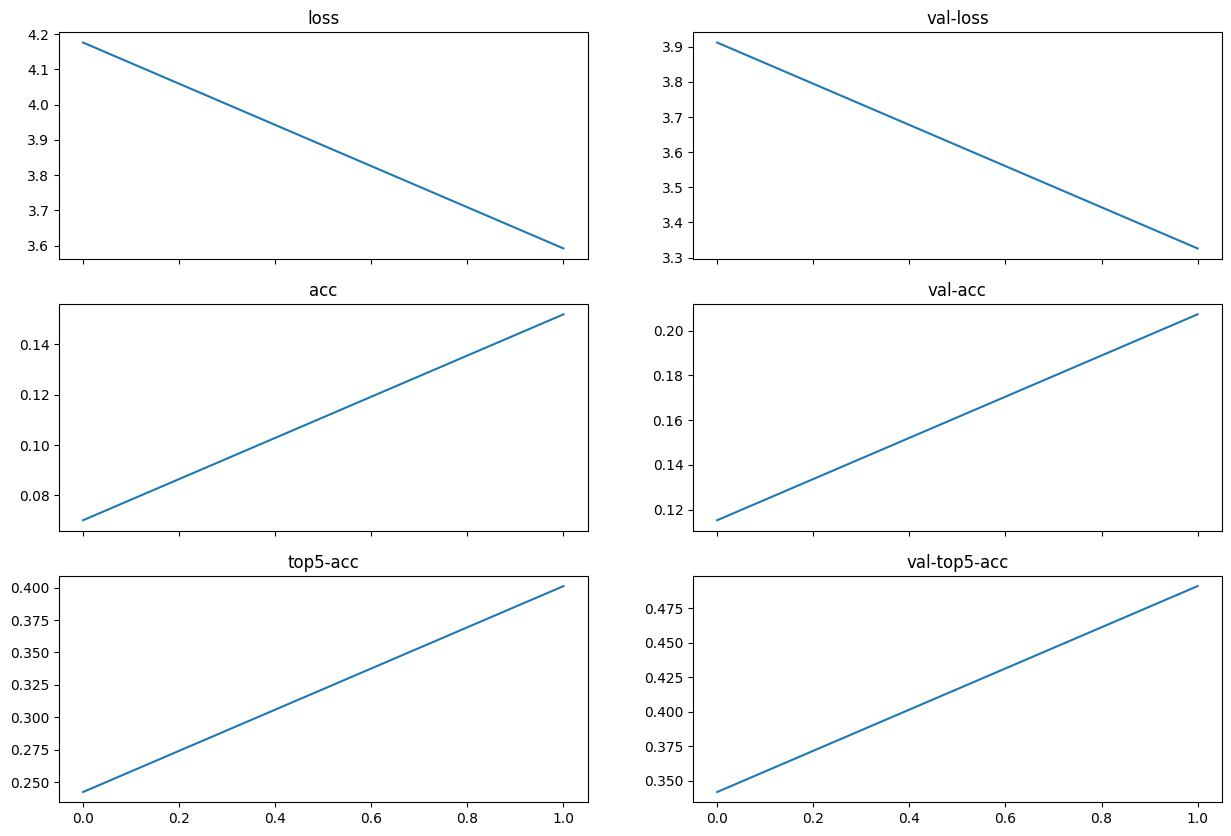

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(15,10), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")
ax[2, 0].set_title("top5-acc")
ax[2, 1].set_title("val-top5-acc")

ax[0, 0].plot(history.history['loss'])
ax[0, 1].plot(history.history['val_loss'])
ax[1, 0].plot(history.history['acc'])
ax[1, 1].plot(history.history['val_acc'])
ax[2, 0].plot(history.history['top5_acc'])
ax[2, 1].plot(history.history['val_top5_acc'])

# Set Up Transfer Learning python

In [ ]:
# Load the pre-trained ResNet model without the top layer (fully connected layer)
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new classifier layers
flat_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
new_top_layer = tf.keras.layers.Dense(128, activation='relu')(flat_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(new_top_layer)  # Assuming binary classification for simplicity

# Define the new model
model = tf.keras.Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

# Load and Prepare the Facial Recognition Dataset

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

def preprocess_image(image, label):
    # Resize images to match the input_shape of the model
    image = tf.image.resize(image, (input_shape[0], input_shape[1]))
    # Normalize images to [0, 1]
    image = image / 255.0
    # Ensure label is of type int32 for comparison
    label = tf.cast(label, tf.int32)
    # Define people classes and ensure the same type for comparison
    people_classes = tf.constant([2, 11, 35, 46, 98], dtype=tf.int32)  # Indices for 'baby', 'boy', 'girl', 'man', 'woman'
    is_person = tf.reduce_any(tf.equal(label, people_classes))
    is_person = tf.cast(is_person, tf.int32)
    return image, is_person

# Load the CIFAR-100 dataset
dataset, info = tfds.load('cifar100', split=['train', 'test'], with_info=True, as_supervised=True)

# Extract train and test datasets
train_data, test_data = dataset

# Apply preprocessing to the dataset
train_dataset = train_data.map(preprocess_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = test_data.map(preprocess_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Fine-Tune the Model on the New Dataset

In [ ]:
# Train the model on the new dataset
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,  # Fine-tuning for fewer epochs
    batch_size=batch_size)

Epoch 1/10
1563/1563 [==============================] - 190s 119ms/step - loss: 0.2042 - accuracy: 0.9494 - val_loss: 0.1974 - val_accuracy: 0.9500
Epoch 2/10
1563/1563 [==============================] - 185s 118ms/step - loss: 0.1993 - accuracy: 0.9500 - val_loss: 0.1974 - val_accuracy: 0.9500
Epoch 3/10
1563/1563 [==============================] - 196s 125ms/step - loss: 0.1985 - accuracy: 0.9500 - val_loss: 0.1970 - val_accuracy: 0.9500
Epoch 4/10
1563/1563 [==============================] - 196s 125ms/step - loss: 0.1980 - accuracy: 0.9500 - val_loss: 0.1966 - val_accuracy: 0.9500
Epoch 5/10
1563/1563 [==============================] - 195s 125ms/step - loss: 0.1975 - accuracy: 0.9500 - val_loss: 0.1962 - val_accuracy: 0.9500
Epoch 6/10
1563/1563 [==============================] - 196s 125ms/step - loss: 0.1971 - accuracy: 0.9500 - val_loss: 0.1960 - val_accuracy: 0.9500
Epoch 7/10
1563/1563 [==============================] - 195s 125ms/step - loss: 0.1967 - accuracy: 0.9500 - val_

# Evaluate the Model

In [ ]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_dataset)
print(f"Model Loss on Validation Dataset: {loss:.4f}")
print(f"Model Accuracy on Validation Dataset: {accuracy*100:.2f}%")

313/313 [==============================] - 32s 103ms/step - loss: 0.1938 - accuracy: 0.9500
Model Loss on Validation Dataset: 0.1938
Model Accuracy on Validation Dataset: 95.00%


# Prediction Fidelity Check

In [ ]:
import numpy as np
# Predict on a batch of images from the validation set and compare with true labels
for images, labels in validation_dataset.take(1):  # Take 1 batch from the dataset
    predictions = model.predict(images)
    predicted_classes = (predictions > 0.5).astype(int)
    true_classes = labels.numpy()
    matches = predicted_classes == true_classes
    fidelity_percent = np.mean(matches) * 100
    print(f"Prediction Fidelity: {fidelity_percent:.2f}%")

1/1 [==============================] - 0s 38ms/step
Prediction Fidelity: 96.88%


# Visual Analysis of the Model Performance

## Plot Learning Curves

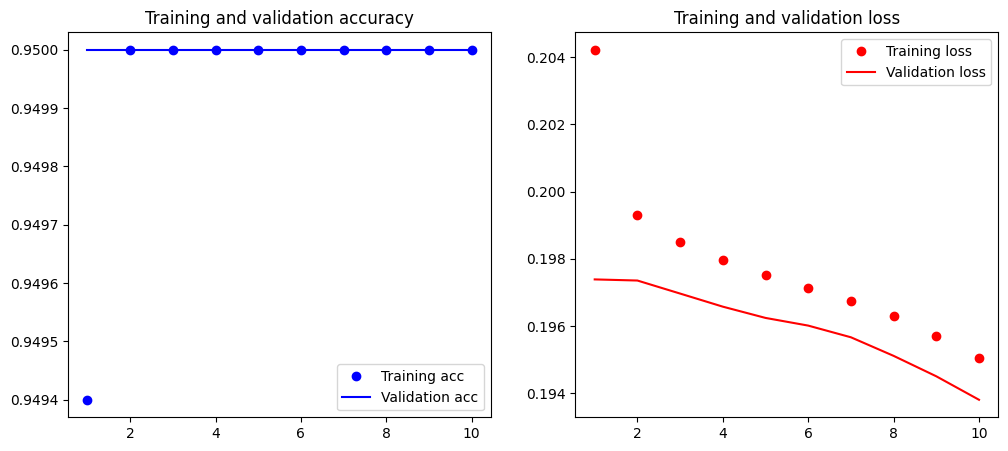

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_learning_curves(history)  # Assuming history is the output from the model.fit()

## Confusion Matrix

32/32 [==============================] - 5s 132ms/step


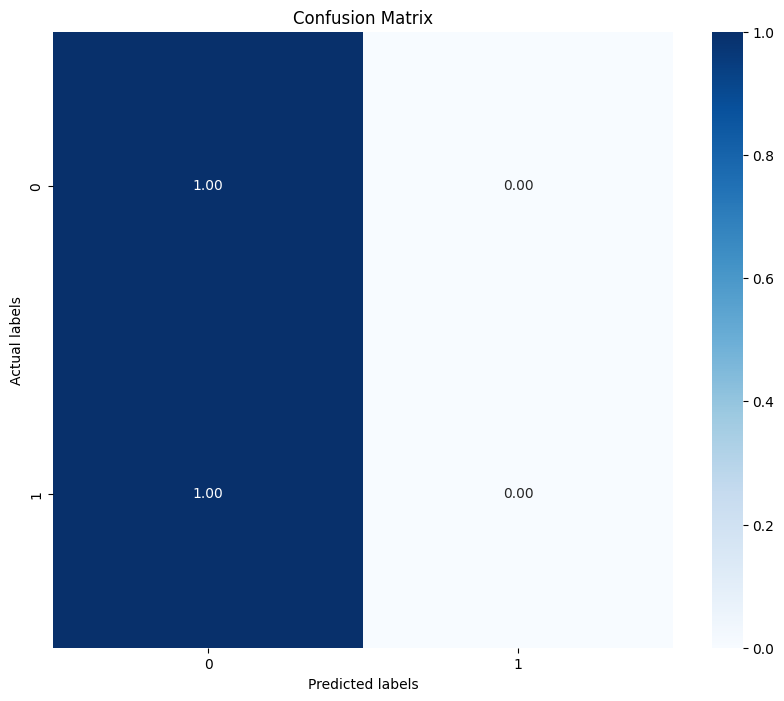

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(validation_dataset, model):
    # Assuming the dataset is batched: unbatch and shuffle it to get a fair mixture
    images, labels = next(iter(validation_dataset.unbatch().batch(1000)))  # Get 1000 samples for plotting
    predictions = model.predict(images)
    predictions = np.argmax(predictions, axis=1)
    cm = confusion_matrix(labels, predictions, normalize='true')

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual labels')
    plt.xlabel('Predicted labels')
    plt.show()

plot_confusion_matrix(validation_dataset, model)  # Call the function with your data and model

## Sample Predictions

1/1 [==============================] - 1s 1s/step


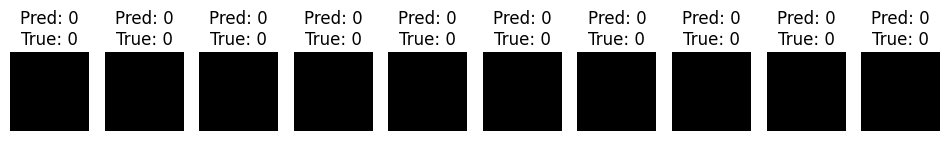

In [ ]:
def display_sample_predictions(validation_dataset, model, num_samples=10):
    images, labels = next(iter(validation_dataset.unbatch().batch(num_samples)))
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    plt.figure(figsize=(12, 4))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'Pred: {predicted_classes[i]}\nTrue: {labels[i]}')
        plt.axis('off')
    plt.show()

display_sample_predictions(validation_dataset, model)  # Display some sample predictions

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import os
from PIL import Image

# Preprocesamiento de las imágenes
def preprocess_image(image, label):
    image = tf.image.resize(image, (input_shape[0], input_shape[1]))
    image = image / 255.0
    people_classes = tf.constant([2, 11, 35, 46, 98], dtype=tf.int64)  # Ensure dtype matches label's dtype
    label = tf.cast(label, tf.int64)  # Explicitly cast label to int64
    is_person = tf.reduce_any(tf.equal(label, people_classes))
    return image, is_person

# Cargar el conjunto de datos CIFAR-100
dataset, info = tfds.load('cifar100', split=['train', 'test'], with_info=True, as_supervised=True)
train_data, test_data = dataset

# Definir la forma de entrada y el tamaño del lote
input_shape = (224, 224, 3)
batch_size = 32

# Aplicar el preprocesamiento
train_dataset = train_data.map(preprocess_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = test_data.map(preprocess_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Definir el modelo base (ResNet50 preentrenado en CIFAR)
base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False, weights='imagenet',
    input_shape=input_shape)

# Congelar los pesos del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas al final del modelo
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Crear el nuevo modelo
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo en el conjunto de datos de reconocimiento facial
model.fit(train_dataset, epochs=num_epochs)

# Evaluar el modelo en el conjunto de prueba de reconocimiento facial
loss, accuracy = model.evaluate(validation_dataset)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

NameError: name 'num_classes' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Obtén un lote de imágenes y etiquetas del conjunto de validación
for images, labels in validation_dataset.take(1):
    # Realiza predicciones con el modelo
    predictions = model.predict(images)

# Obtén las etiquetas predichas (el índice de la clase con la mayor probabilidad)
predicted_labels = tf.argmax(predictions, axis=1)

# Muestra las primeras 25 imágenes, sus etiquetas predichas y las etiquetas verdaderas
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    # Las etiquetas predichas son azules y las etiquetas verdaderas son verdes
    plt.xlabel(f"{predicted_labels[i]}, {labels[i]}")
plt.show()
